# Parameter normalization and variable dependencies

## Parameter Normalization
Most optimization algorithms struggle when optimization variables spread over multiple orders of magnitude.
**CADET-Process** provides several transformation methods which can help to soften these challenges.

In the following, $x$ will always refer to what the `Optimizer` "sees", whereas $Variable$ refers to the actual optimization parameter.
Internally, before the objective functiton is evaluated, the transformed parameter needs to be untransformed.

#ToDo: What do you think about another illustration, such as this quick doodle:

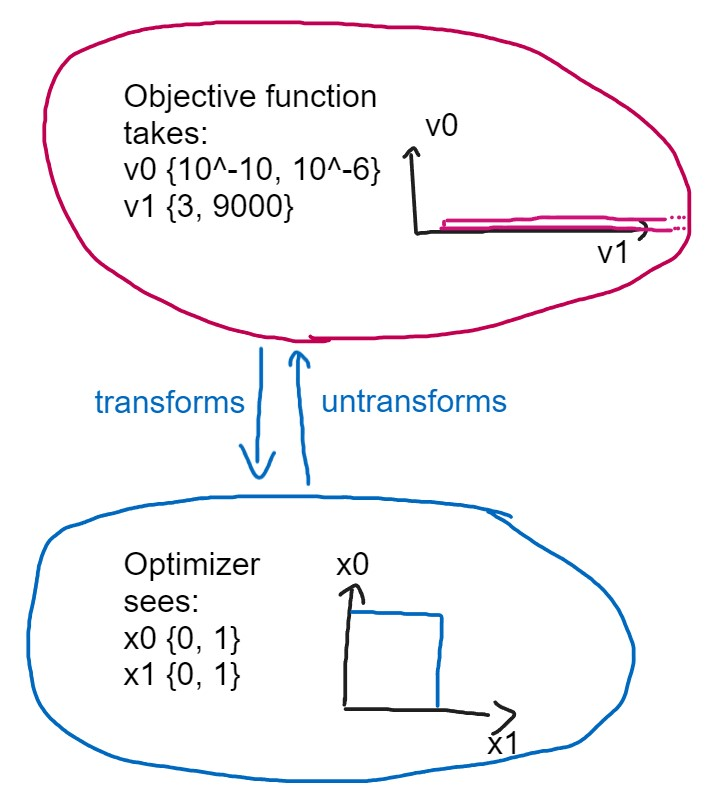

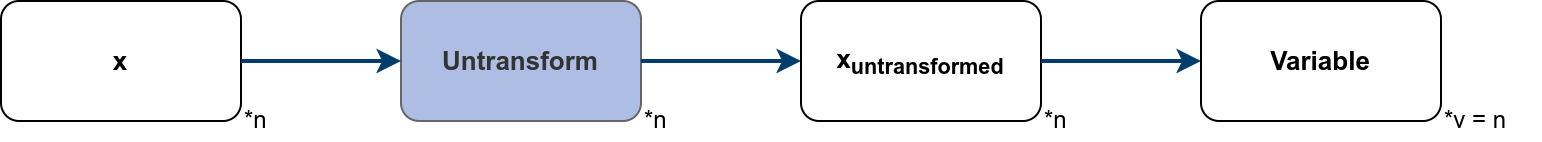



### Linear Normalization
The linear normalization maps the variable space from the lower and upper bound to a range between $0$ and $1$ by applying the following transformation:

$$
x^\prime = \frac{x - x_{lb}}{x_{ub} - x_{lb}}
$$

In [49]:
from CADETProcess.optimization import OptimizationProblem

optimization_problem = OptimizationProblem('transform_demo')
optimization_problem.add_variable('var_lin', lb=-100, ub=100, transform='linear')

### Log Normalization
The log normalization maps the variable space from the lower and upper bound to a range between $0$ and $1$ by applying the following transformation:

$$
x^\prime = \frac{log \left( \frac{x}{x_{lb}} \right) }{log \left( \frac{x_{ub} }{x_{lb}} \right) }
$$

In [50]:
optimization_problem.add_variable('var_log', lb=-100, ub=100, transform='log')

### Auto Transform
This transform will automatically switch between a linear and a log transform if the ratio of upper and lower bounds is larger than some value ($1000$ by default).

In [51]:
optimization_problem.add_variable('var_auto', lb=-100, ub=100, transform='auto')

## Variable Dependencies
In addition to normalization methods, dependencies 

- dependencies between variables.
- e.g. apply to multiple units
- e.g. use for pre-processing
- Will not be exposed to optimizer
- different mechanisms:
    - linear combination
    - custom function

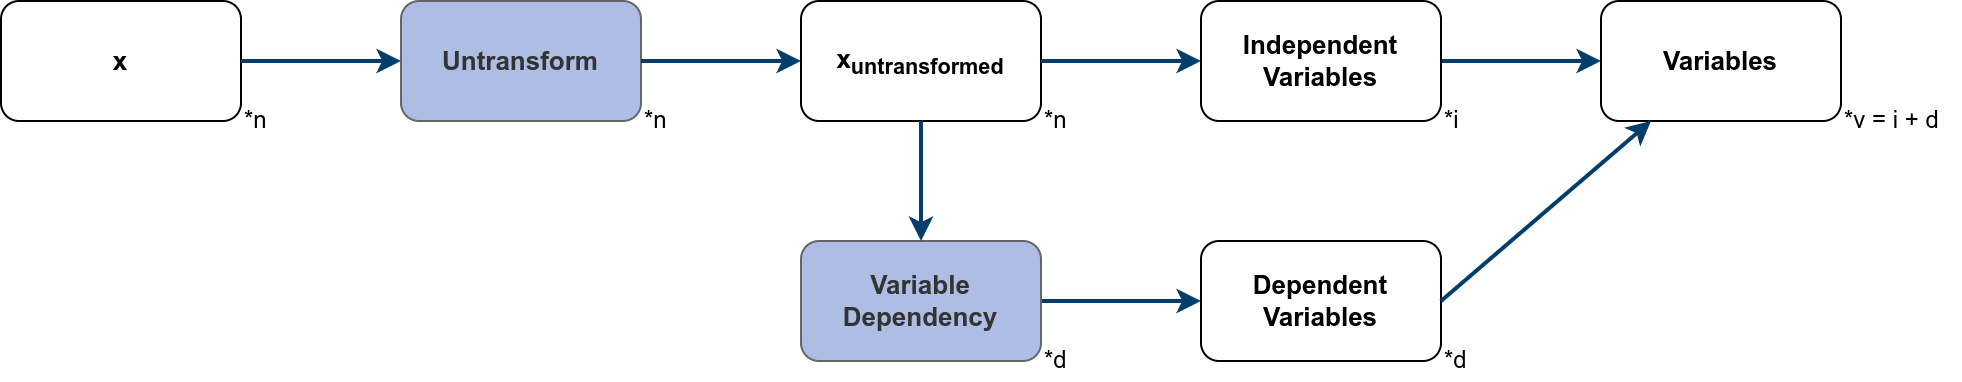

For example, consider an `OptimizationProblem` where the ratio of two variables should be considered as a third variable.

It would be nice, if the `Optimizer` would only need to worry about the two _independent_ variabels while the `OptimizationProblem` handles the third, _dependent_ variable in the background automatically.

First, all variables need to be added.

In [54]:
optimization_problem = OptimizationProblem('dependency_demo')

optimization_problem.add_variable('var_0')
optimization_problem.add_variable('var_1')
optimization_problem.add_variable('var_2')

To add the dependency, the dependent variable needs to be specified, as well as a list of the independent variables.
Finally, a callable that takes the independent variables and returns the value of the dependent variable value needs to be added.

In [55]:
def transform_fun(var_0, var_1):
    return var_0/var_1

optimization_problem.add_variable_dependency('var_2', ['var_0', 'var_1'], transform=transform_fun)

Now, for example if a point $[1.0, 2.0]$ is to be evaluated, the value for $var_2$ is computed the following way:

In [56]:
optimization_problem.get_dependent_values([1, 2])

[1.0, 2.0, 0.5]

Note that generally bounds, transforms, and linear constraints can still be specified independently for all variables.

## Example: $k_{eq}$

When estimating adsorption model parameters, often, the equilibrium constant $k_{eq}$ can be estimated independently (e.g. using Yamamoto's method).
Then, the kinetic coeffitient is estimated.

$$
k_{eq} = \frac{k_{ads}}{k_{des}}
$$

and

$$
k_{ads} = \frac{k_{eq}}{k_{kin}}
$$


However, in CADET, $k_{ads}$ and $k_{des}$ need to be specified separately.
To setup this system, dependencies (and transform functions) can be used.

In [6]:
from CADETProcess.optimization import OptimizationProblem
optimization_problem = OptimizationProblem('dependency_demo')

k_eq = 0.1

optimization_problem.add_variable('k_kin')
optimization_problem.add_variable('k_ads')
optimization_problem.add_variable('k_des')

def transform_k_ads(k_kin):
    return k_eq/k_kin

optimization_problem.add_variable_dependency('k_ads', ['k_kin'], transform=transform_k_ads)

def transform_k_des(k_kin):
    return 1/k_kin

optimization_problem.add_variable_dependency('k_des', ['k_kin'], transform=transform_k_des)


def objective(x):
    print(x)
    return 1

optimization_problem.add_objective(objective)


In [10]:
optimization_problem.independent_variable_names

['k_kin']

In [7]:
optimization_problem.get_dependent_values([1])

[1.0, 0.1, 1.0]